# Qubitized Hubbard Model

Simulating the Hubbard model Hamiltonian using qubitization.

This module follows section V. of Encoding Electronic Spectra in Quantum Circuits with Linear T
Complexity. Babbush et. al. 2018. [arxiv:1805.03662](https://arxiv.org/abs/1805.03662).

The 2D Hubbard model is a special case of the electronic structure Hamiltonian
restricted to spins on a planar grid.

$$
H = -t \sum_{\langle p,q \rangle, \sigma} a_{p,\sigma}^\dagger a_{q,\sigma}
    + \frac{u}{2} \sum_{p,\alpha\ne\beta} n_{p, \alpha} n_{p, \beta}
$$

Under the Jordan-Wigner transformation to Pauli operators, this is

$$
\def\Zvec{\overrightarrow{Z}}
\def\hop#1{#1_{p,\sigma} \Zvec #1_{q,\sigma}}
H = -\frac{t}{2} \sum_{\langle p,q \rangle, \sigma} (\hop{X} + \hop{Y})
  + \frac{u}{8} \sum_{p,\alpha\ne\beta} Z_{p,\alpha}Z_{p,\beta}
  - \frac{u}{4} \sum_{p,\sigma} Z_{p,\sigma} + \frac{uN}{4}\mathbb{1}
$$

This can be simulated using a qubitization circuit, which consists of PREPARE and SELECT
operations. This module contains `SelectHubbard` and `PrepareHubbard`, with particular
compilation optimizations for the Hubbard model. For more insight into how Select and Prepare
operations can be combined into a quantum walk, please see
[Qubitization Walk Operator](./qubitization_walk_operator.ipynb).

With these operators, our selection register has indices
for $p$, $\alpha$, $q$, and $\beta$ as well as two indicator bits $U$ and $V$. There are four cases
considered in both the PREPARE and SELECT operations corresponding to the terms in the Hamiltonian:

 - $U=1$, single-body Z
 - $V=1$, spin-spin ZZ term
 - $p<q$, XZX term
 - $p>q$, YZY term.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `SelectHubbard`
The SELECT operation optimized for the 2D Hubbard model.

In contrast to SELECT for an arbitrary chemistry Hamiltonian, we:
 - explicitly consider the two dimensions of indices to permit optimization of the circuits.
 - dispense with the `theta` index for phases.

If neither $U$ nor $V$ is set we apply the kinetic terms of the Hamiltonian:

$$
-\hop{X} \quad p < q \\
-\hop{Y} \quad p > q
$$

If $U$ is set we know $(p,\alpha)=(q,\beta)$ and apply the single-body term: $-Z_{p,\alpha}$.
If $V$ is set we know $p=q, \alpha=0$, and $\beta=1$ and apply the spin term:
$Z_{p,\alpha}Z_{p,\beta}$

`SelectHubbard`'s construction uses $10 * N + log(N)$ T-gates.

#### Parameters
 - `x_dim`: the number of sites along the x axis.
 - `y_dim`: the number of sites along the y axis.
 - `control_val`: Optional bit specifying the control value for constructing a controlled version of this gate. Defaults to None, which means un-controlled. 

#### Registers
 - `control`: A control bit for the entire gate.
 - `U`: Whether we're applying the single-site part of the potential.
 - `V`: Whether we're applying the pairwise part of the potential.
 - `p_x`: First set of site indices, x component.
 - `p_y`: First set of site indices, y component.
 - `alpha`: First set of sites' spin indicator.
 - `q_x`: Second set of site indices, x component.
 - `q_y`: Second set of site indices, y component.
 - `beta`: Second set of sites' spin indicator.
 - `target`: The system register to apply the select operation. 

#### References
 - [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662). Section V. and Fig. 19.


In [2]:
from qualtran.bloqs.chemistry.hubbard_model.qubitization import SelectHubbard

### Example Instances

In [3]:
x_dim = 4
y_dim = 4
sel_hubb = SelectHubbard(x_dim, y_dim)

#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([sel_hubb],
           ['`sel_hubb`'])

### Call Graph

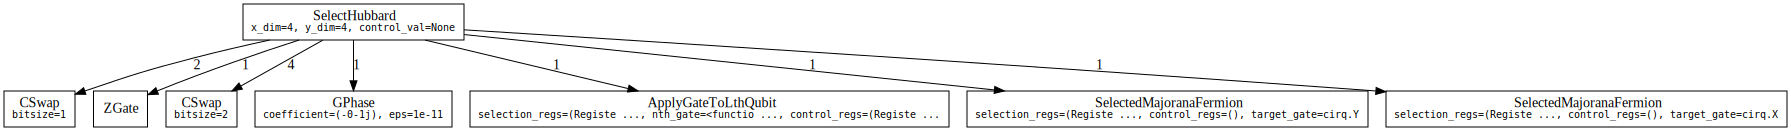

#### Counts totals:
 - `ApplyGateToLthQubit`: 1
 - `CSwap`: 2
 - `CSwap`: 4
 - `GPhase((-0-1j))`: 1
 - `SelectedMajoranaFermion(X)`: 1
 - `SelectedMajoranaFermion(Y)`: 1
 - `ZGate`: 1

In [5]:
from qualtran.resource_counting.generalizers import ignore_split_join
sel_hubb_g, sel_hubb_sigma = sel_hubb.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(sel_hubb_g)
show_counts_sigma(sel_hubb_sigma)

## `PrepareHubbard`
The PREPARE operation optimized for the 2D Hubbard model.

In contrast to PREPARE for an arbitrary chemistry Hamiltonian, we:
 - explicitly consider the two dimensions of indices to permit optimization of the circuits.
 - dispense with the `theta` index for phases.

`PrepareHubbard` uses $O(\log(N))$ T gates and $O(1)$ single-qubit rotations.

#### Parameters
 - `x_dim`: the number of sites along the x axis.
 - `y_dim`: the number of sites along the y axis.
 - `t`: coefficient for hopping terms in the Hubbard model hamiltonian.
 - `u`: coefficient for single body Z term and two-body ZZ terms in the Hubbard model hamiltonian. 

#### Registers
 - `control`: A control bit for the entire gate.
 - `U`: Whether we're applying the single-site part of the potential.
 - `V`: Whether we're applying the pairwise part of the potential.
 - `p_x`: First set of site indices, x component.
 - `p_y`: First set of site indices, y component.
 - `alpha`: First set of sites' spin indicator.
 - `q_x`: Second set of site indices, x component.
 - `q_y`: Second set of site indices, y component.
 - `beta`: Second set of sites' spin indicator.
 - `target`: The system register to apply the select operation.
 - `junk`: Temporary Work space. 

#### References
 - [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662). Section V. and Fig. 20.


In [6]:
from qualtran.bloqs.chemistry.hubbard_model.qubitization import PrepareHubbard

### Example Instances

In [7]:
x_dim = 4
y_dim = 4
t = 1.0
u = 4.0 / t
prep_hubb = PrepareHubbard(x_dim, y_dim, t=t, u=u)

#### Graphical Signature

In [8]:
from qualtran.drawing import show_bloqs
show_bloqs([prep_hubb],
           ['`prep_hubb`'])

### Call Graph

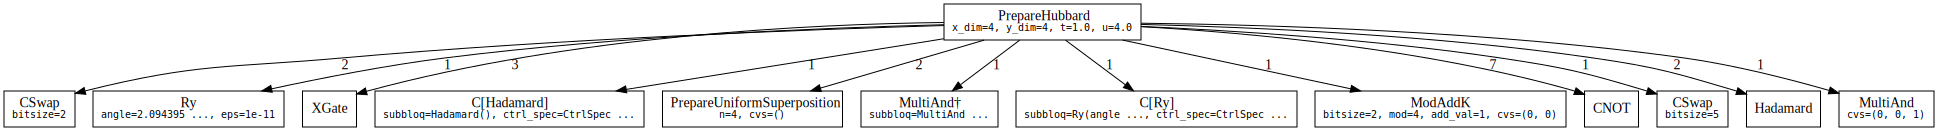

#### Counts totals:
 - `Adjoint(subbloq=MultiAnd(n=3))`: 1
 - `CNOT`: 7
 - `CSwap`: 1
 - `CSwap`: 2
 - `C[H]`: 1
 - `C[Ry(0.7048327646991335π)]`: 1
 - `H`: 2
 - `ModAddK`: 1
 - `MultiAnd(n=3)`: 1
 - `PrepareUniformSuperposition`: 2
 - `Ry(0.6666666666666667π)`: 1
 - `XGate`: 3

In [9]:
from qualtran.resource_counting.generalizers import ignore_split_join
prep_hubb_g, prep_hubb_sigma = prep_hubb.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(prep_hubb_g)
show_counts_sigma(prep_hubb_sigma)